# **Assignment 3:** Spatio-Temporal Segmentation

### Utilities

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plotFn(row, col, f_s, img_list, title, color=None):
    l = len(img_list)
    if l==0:
        return "Empty list!"
    fig, axes = plt.subplots(row,col,figsize=f_s)

    for i in range(row):
        for j in range(col):
            n = col*i + j
            if n>=l:
                break
            axes[i][j].imshow(img_list[n],cmap=color)
            axes[i][j].set_xticks([])
            axes[i][j].set_yticks([])
            axes[i][j].set_title(title + " " + str(n))
    
    plt.show()

## **1. Load Video:** Load the provided video file

In [3]:
vid_path = r'videos/video2.mp4'
video = cv2.VideoCapture(vid_path)

## **2. Frame Extraction:** Extract individual frames from the video

In [4]:
success = 1
count = 0

In [5]:
#frame list
frame_list = []

In [6]:
while success:
    success, frame = video.read()
    if success:
        count+=1
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        frame_list.append(frame)
video.release()

In [7]:
len(frame_list)

284

First four frames of the video

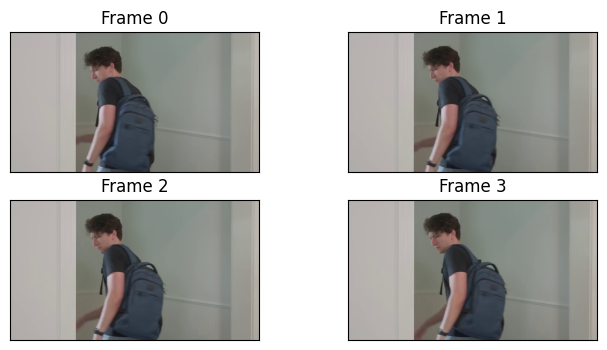

In [8]:
plotFn(2, 2, (8,4), frame_list, "Frame")

## **3. Spatio-Temporal Segmentation:**

### Perform segmentation on each frame using a technique like color thresholding or edge detection.

In [9]:
def convolution(image,kernel,const):
    op_size = (image.shape[0]-kernel.shape[0]+1,image.shape[1]-kernel.shape[1]+1)
    conv_op = np.zeros(op_size)
    X,Y = conv_op.shape
    for i in range(X):
        for j in range(Y):
            conv_op[i,j] = np.sum(np.multiply(image[i:i+3,j:j+3],kernel))//const
    return conv_op

In [10]:
def sobelEdgeDetection(frame):
    g_x = np.asarray([[-1,0,1],[-2,0,2],[-1,0,1]],dtype=np.int32)
    g_y = np.rot90(g_x)
    sobel_x = convolution(frame,g_x,1)
    sobel_y = convolution(frame,g_y,1)
    sobel_final = np.sqrt(sobel_x**2+sobel_y**2)
    return sobel_final

### Track the segmented objects across frames to observe changes in motion and shape.

In [11]:
edge_frame_list = []
success = 1
video2 = cv2.VideoCapture(vid_path)
count = 0

In [12]:
while success:
    success, frame = video2.read()
    if success:
        count+=1
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        edge_frame = sobelEdgeDetection(frame)
        edge_frame_list.append(edge_frame)
    if count>=6:
        break

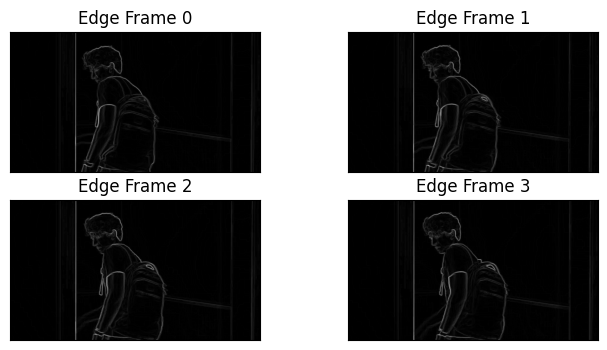

In [13]:
plotFn(2, 2, (8,4), edge_frame_list, "Edge Frame",'gray')

In [14]:
video = cv2.VideoCapture(vid_path)

### Identify the regions that remain consistent over time.

Skipping frames for computational simplicity

In [15]:
n_frames = 50
len_frame_list = len(frame_list)
step = len_frame_list//n_frames
edge_check_frames = []

In [16]:
for i in range(0,len_frame_list,step):
    frame = frame_list[i]
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    edge_check = sobelEdgeDetection(frame)
    edge_check_frames.append(edge_check)

In [17]:
len(edge_check_frames)

57

### Edge detection on the sampled frames

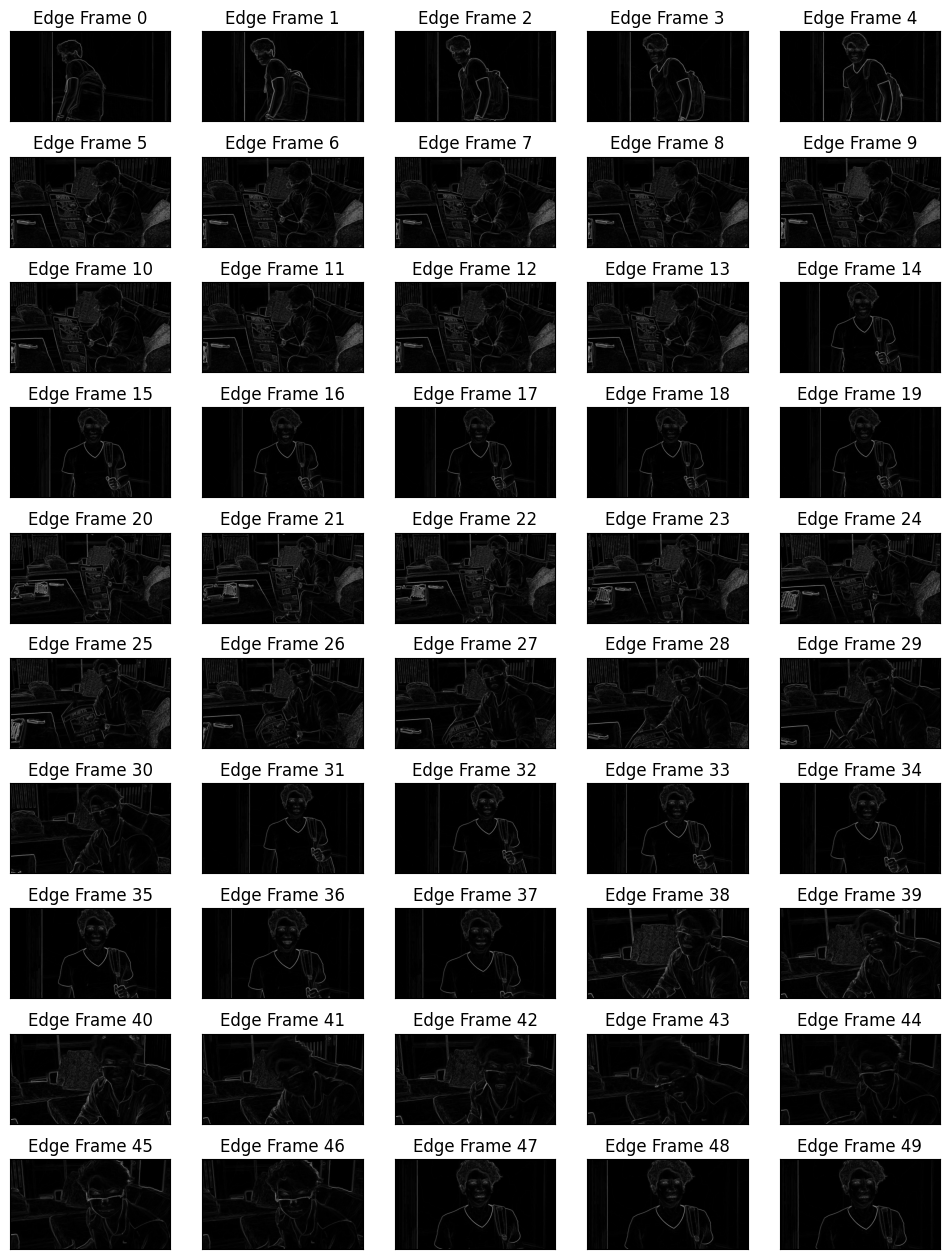

In [18]:
plotFn(10, 5, (12,16), edge_check_frames, "Edge Frame",'gray')

## **4. Scene Cut Detection** 

### Use pixel-based comparison or histogram differences between consecutive frames to detect abrupt changes (hard cuts).

In [19]:
def sumPixelWiseDiff(frame1,frame2):
    return np.sum(np.ravel(np.abs(frame1-frame2)))/(frame1.shape[0]*frame1.shape[1]*3)

In [20]:
n_frames = 50
len_frame_list = len(frame_list)
step = len_frame_list//n_frames

In [21]:
sample_frame_list = []
for i in range(1,len_frame_list,step):
    sample_frame_list.append(frame_list[i])

### Sample frames used from the footage

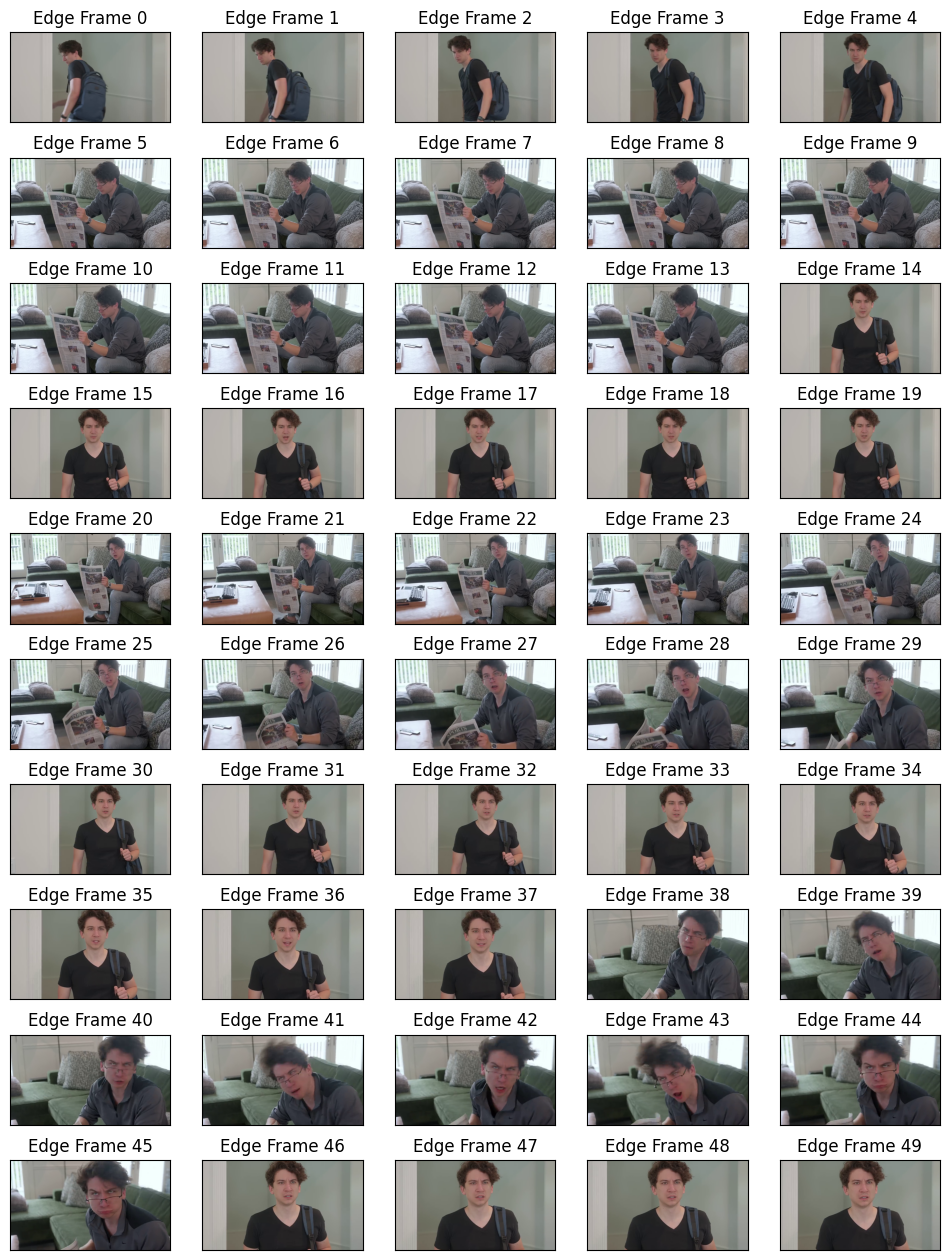

In [22]:
plotFn(10, 5, (12,16), sample_frame_list, "Edge Frame")

In [23]:
for i in range(0,len(sample_frame_list)):
    print(int(sumPixelWiseDiff(sample_frame_list[i-1],sample_frame_list[i])),end=" ")

164 52 54 41 53 137 111 107 106 97 97 97 88 102 119 62 44 50 52 35 128 125 124 124 125 111 109 119 120 119 121 62 83 101 95 80 93 91 120 116 99 109 105 109 101 96 124 92 84 94 81 77 87 80 83 92 84 

## **5. Mark Scene cuts**

### Highlight the frames where scene cuts are detected.
### Create a summary displaying the detected scene boundaries.

In [24]:
#defining hard cut threshold
hard_cut_threshold = 124.5
hard_cuts = []
for i in range(0,len(sample_frame_list)):
    diff = sumPixelWiseDiff(sample_frame_list[i-1],sample_frame_list[i])
    if diff>hard_cut_threshold:
        print("Hard cut at ",i)
        hard_cuts.append(i)
        print("Value: ",round(diff,3))

Hard cut at  0
Value:  164.103
Hard cut at  5
Value:  137.474
Hard cut at  20
Value:  128.165
Hard cut at  21
Value:  125.164
Hard cut at  24
Value:  125.508
Hard cut at  46
Value:  124.582


### Detect gradual scene transitions (Soft cuts) by analyzing frame-to-frame intensity changes over time.

In [25]:
#defining soft cut threshold
soft_cut_threshold = 110
soft_cuts = []
for i in range(0,len(sample_frame_list)):
    diff = sumPixelWiseDiff(sample_frame_list[i-1],sample_frame_list[i])
    if diff>soft_cut_threshold and diff<hard_cut_threshold:
        print("Soft cut at ",i)
        soft_cuts.append(i)
        print("Value: ",round(diff,3))

Soft cut at  6
Value:  111.464
Soft cut at  14
Value:  119.677
Soft cut at  22
Value:  124.28
Soft cut at  23
Value:  124.004
Soft cut at  25
Value:  111.67
Soft cut at  27
Value:  119.589
Soft cut at  28
Value:  120.661
Soft cut at  29
Value:  119.597
Soft cut at  30
Value:  121.721
Soft cut at  38
Value:  120.612
Soft cut at  39
Value:  116.062


## **6. Result Visualization:** 
### Display frames where scene cuts are identified and show segmentation results for selected frames

In [26]:
len(hard_cuts), len(soft_cuts)

(6, 11)

### Hard cuts

In [27]:
hard_cut_frames = []
for i in hard_cuts:
    hard_cut_frames.append(sample_frame_list[i-1])
    hard_cut_frames.append(sample_frame_list[i])

In [28]:
hard_cuts

[0, 5, 20, 21, 24, 46]

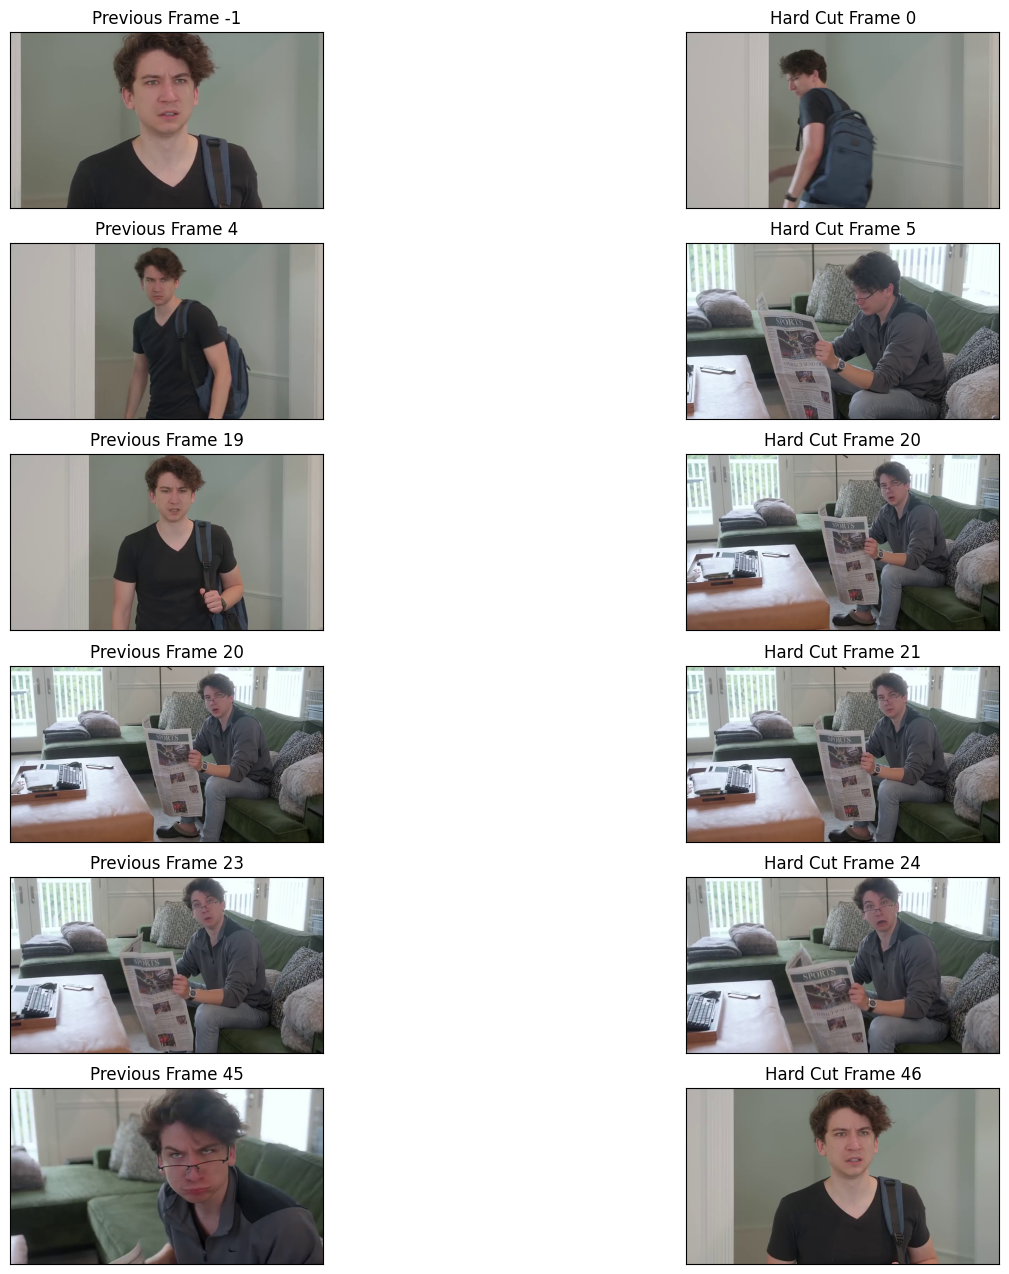

In [29]:
l = len(hard_cut_frames)
row, col = 6,2
prev = 1
fig, axes = plt.subplots(row, col,figsize=(16,16))
for i in range(row):
    for j in range(col):
        n = col*i + j
        if n>=l:
            break
        title = "Previous Frame " + str(hard_cuts[n//2] - 1) if prev==1 else "Hard Cut Frame " + str(hard_cuts[n//2])
        prev = 0 if prev==1 else 1
        axes[i][j].imshow(hard_cut_frames[n])
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
        axes[i][j].set_title(title)
plt.show()

### Segmentation of hard cuts

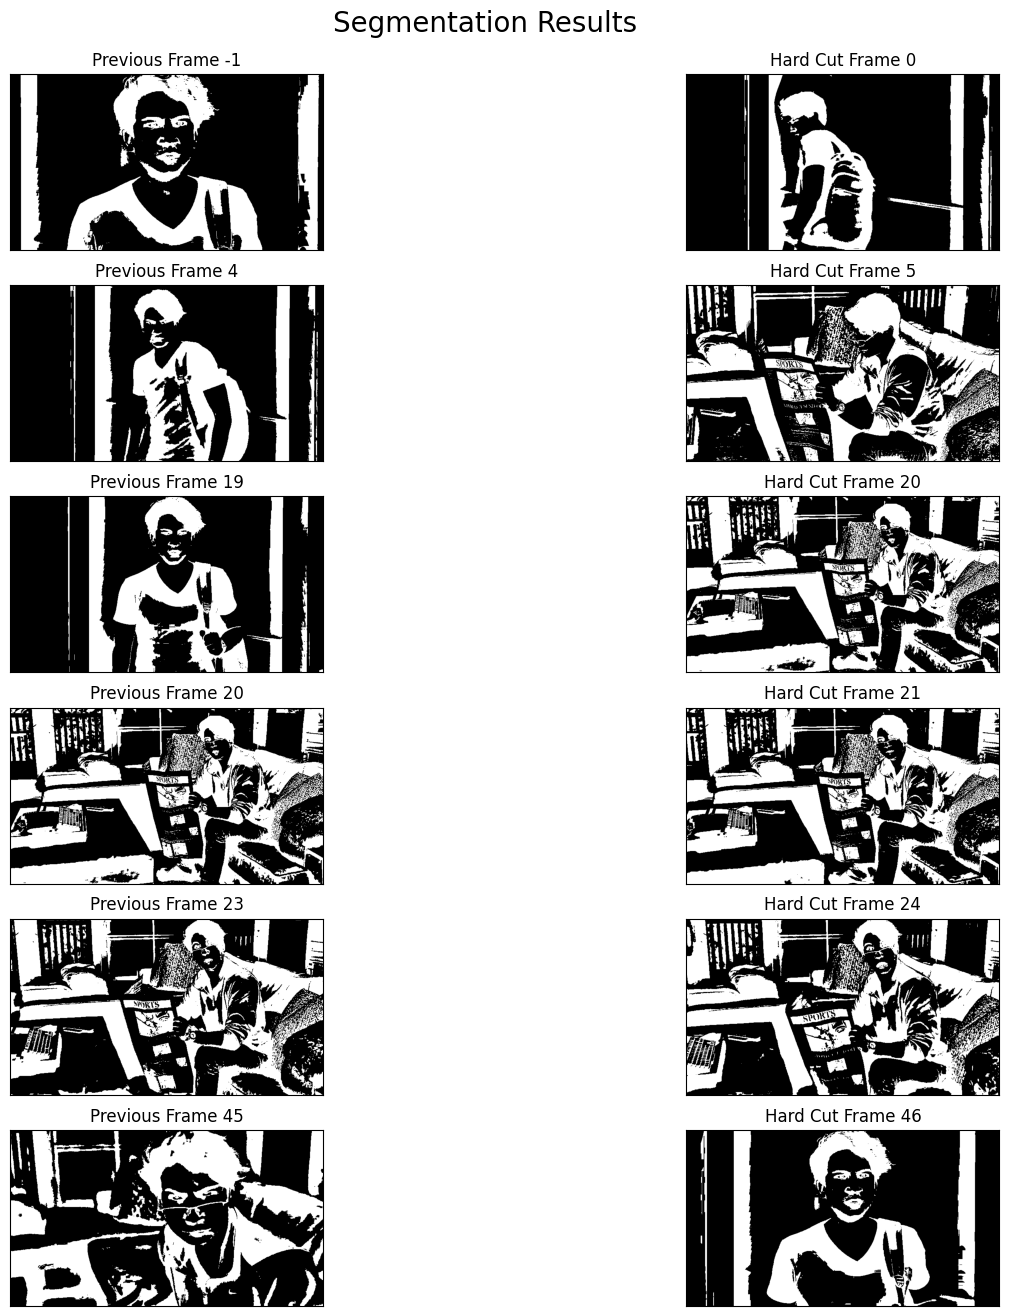

In [30]:
#segmentation results
l = len(hard_cut_frames)
row, col = 6,2
prev = 1
fig, axes = plt.subplots(row, col,figsize=(16,16))
for i in range(row):
    for j in range(col):
        n = col*i + j
        if n>=l:
            break
        title = "Previous Frame " + str(hard_cuts[n//2] - 1) if prev==1 else "Hard Cut Frame " + str(hard_cuts[n//2])
        prev = 0 if prev==1 else 1
        img = cv2.cvtColor(hard_cut_frames[n],cv2.COLOR_RGB2GRAY)
        thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 199, 5) 
        axes[i][j].imshow(thresh,cmap='binary')
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
        axes[i][j].set_title(title)
        
fig.suptitle('Segmentation Results',fontsize=20, y=0.92)
plt.show()

### Soft cuts

In [31]:
#soft cuts
soft_cut_frames = []
for i in soft_cuts:
    soft_cut_frames.append(sample_frame_list[i-1])
    soft_cut_frames.append(sample_frame_list[i])
    soft_cut_frames.append(sample_frame_list[i+1])

In [32]:
len(soft_cuts)

11

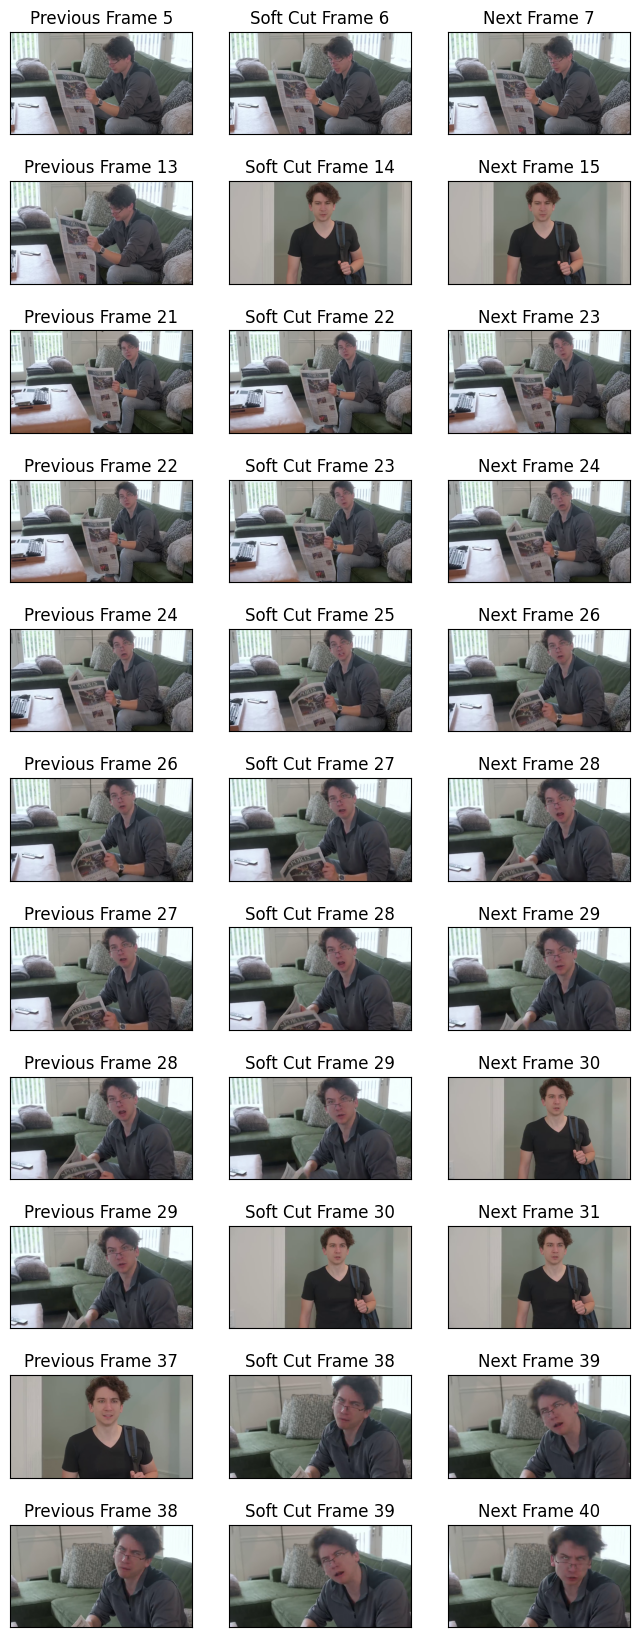

In [33]:
l = len(soft_cut_frames)
row, col = 11, 3
prev = 0
fig, axes = plt.subplots(row, col,figsize=(8,21))
for i in range(row):
    for j in range(col):
        n = col*i + j
        if n>=l:
            break
        if prev==0:
            title = "Previous Frame " + str(soft_cuts[n//3] - 1)
        else:
            title = "Soft Cut Frame " + str(soft_cuts[n//3]) if prev==1 else "Next Frame " + str(soft_cuts[n//3]+1)
        prev = (prev+1)%3
        axes[i][j].imshow(soft_cut_frames[n])
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
        axes[i][j].set_title(title)
plt.show()

### Segmentation of soft cuts

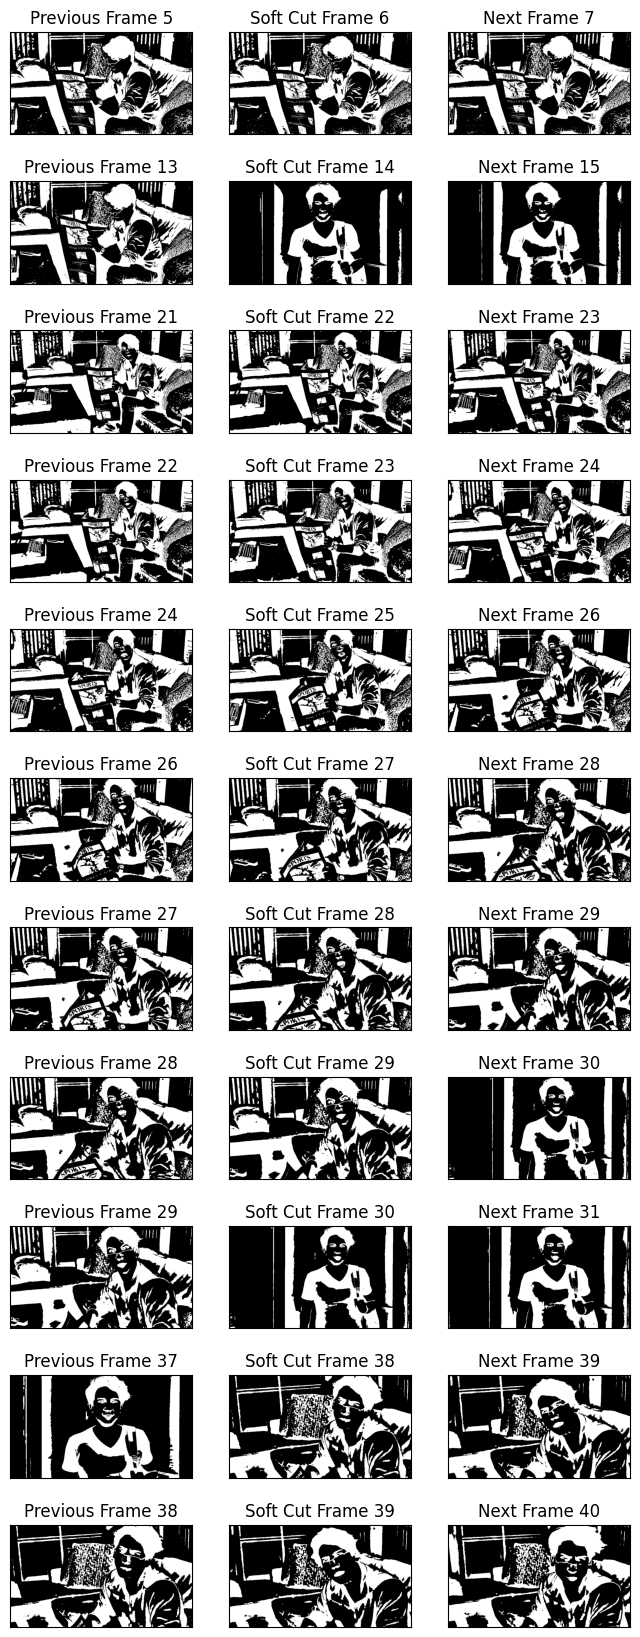

In [34]:
l = len(soft_cut_frames)
row, col = 11, 3
prev = 0
fig, axes = plt.subplots(row, col,figsize=(8,21))
for i in range(row):
    for j in range(col):
        n = col*i + j
        if n>=l:
            break
        if prev==0:
            title = "Previous Frame " + str(soft_cuts[n//3] - 1)
        else:
            title = "Soft Cut Frame " + str(soft_cuts[n//3]) if prev==1 else "Next Frame " + str(soft_cuts[n//3]+1)
        prev = (prev+1)%3
        img = cv2.cvtColor(soft_cut_frames[n],cv2.COLOR_RGB2GRAY)
        thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 199, 5) 
        axes[i][j].imshow(thresh,cmap='binary')
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
        axes[i][j].set_title(title)
plt.show()